In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from joblib import Parallel, delayed
from scipy.integrate import nquad, quad, simps
from scipy.stats import entropy, gamma, multivariate_normal, norm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier, build_coleman_forest
from sktree.tree import DecisionTreeClassifier

In [3]:
SIMULATIONS = {
    "1": {},
    "2": {"m_factor": 1},
    "3": {"band_type": "ar", "rho": 0.5},
    "4": {"band_type": "ar", "m_factor": 1, "rho": 0.5},
}

In [4]:
def _perm_stat(est, sim, n=100, p=1, **kwargs):
    """
    Generates null and alternate distributions
    """
    est.reset()
    x, y, mu, cov = make_trunk_classification(
        n_samples=n, n_dim=p, **SIMULATIONS[sim], return_params=True
    )
    x = np.float32(x)
    y = np.float32(y)
    _, obs_stat = est.statistic(x, y, **kwargs)
    permv = np.random.permutation(y)
    est.reset()
    _, perm_stat = est.statistic(x, permv, **kwargs)
    est.reset()

    return obs_stat, perm_stat


def _nonperm_pval(est, sim, n=100, p=1, noise=True, **kwargs):
    """
    Generates fast  permutation pvalues
    """
    est.reset()
    x, y, mu, cov = make_trunk_classification(
        n_samples=n, n_dim=p, **SIMULATIONS[sim], return_params=True
    )
    x = np.float32(x)
    y = np.float32(y)
    est.reset()
    pvalue = est.test(x, y, metric="s@98")[1]
    est.reset()
    return pvalue

In [34]:
SAMP_SIZES = [2**i for i in range(8, 12)]
SAMP_SIZES_plot = [2 * 2**i for i in range(8, 10)]
DIM = 4**6
REPS = range(100, 1000)
P = 4096
SAVE_PATH = "/Volumes/Extreme Pro/cancer/output/power_exp"
print(SAMP_SIZES)

[256, 512, 1024, 2048]


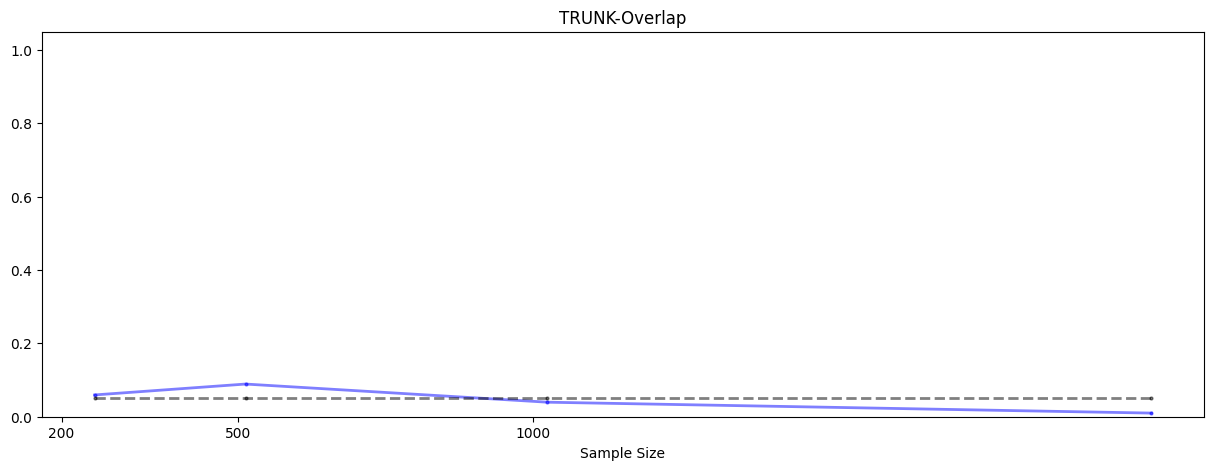

In [36]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 14))

SAMP_SIZES = [2**i for i in range(8, 12)]
SAMP_SIZES_plot = [2**i for i in range(8, 12)]


plt.rcParams["font.size"] = 10
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
REPs = 20
ALPHA = 0.05
for sim in ["2"]:
    power_MIGHT = []
    for n in SAMP_SIZES:
        pvals = []
        for idx in range(100):
            file_name = "{}/{}_{}_{}_{}.txt".format(
                SAVE_PATH, sim, "MIGHT_Coleman_pertree", n, idx
            )
            if not os.path.exists(file_name):
                continue
            pval = np.loadtxt(file_name)[1]
            pvals.append(pval)
        empirical_power = (1 + (np.array(pvals) <= 0.05).sum()) / (1 + 100)
        # empirical_power = (np.array(pvals) < 0.05).sum() / len(pvals)
        # empirical_power = (np.array(pvals) < 0.05).sum() / (100)
        power_MIGHT.append(empirical_power)

        # power_MIGHT_Coleman.append(empirical_power)

        # power_MIGHT_Coleman = []
        # for n in SAMP_SIZES:
        #     df2 = np.genfromtxt(
        #         "/Users/baiyuxin/Desktop/JHU/NDD/Cancer/df2_coleman.csv", delimiter=","
        #     )[1:]
        #     df_sim = df2[df2[:, 1] == int(sim)]
        #     df_samp = df_sim[df_sim[:, 2] == n]
        #     pvals = df_samp[:, 3]
        # empirical_power = (1 + (pvals <= 0.05).sum()) / (1 + 100)
        # power_MIGHT_Coleman.append(empirical_power)

    # power_MIGHT_Coleman_pertree = []
    # for n in SAMP_SIZES:
    #     file_name = "{}/{}_{}_{}".format(SAVE_PATH, sim, "MIGH_Coleman_pertree", n)
    #     pvals = np.array(
    #         [np.genfromtxt("{}_{}.txt".format(file_name, rep)) for rep in range(REPs)]
    #     )
    #     empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + REPs)
    #     power_MIGHT_Coleman_pertree.append(empirical_power)

    axs.plot(
        SAMP_SIZES_plot,
        power_MIGHT,
        "blue",
        marker="o",
        markersize=2,
        label="MIGHT",
        linewidth=2,
        alpha=0.5,
    )
    # axs[int(sim) - 1].plot(
    #     SAMP_SIZES_plot,
    #     power_MIGHT_Coleman,
    #     "green",
    #     marker="o",
    #     markersize=2,
    #     label="MIGHT_Coleman",
    #     linewidth=2,
    #     alpha=0.5,
    # )
    # axs[int(sim) - 1].plot(
    #     SAMP_SIZES_plot,
    #     power_MIGHT_Coleman_pertree,
    #     "red",
    #     marker="o",
    #     markersize=2,
    #     label="MIGHT_Coleman_Pertree",
    #     linewidth=2,
    #     alpha=0.5,
    # )
    axs.plot(
        SAMP_SIZES_plot,
        ALPHA * np.ones(len(SAMP_SIZES_plot)),
        "black",
        linestyle="dashed",
        marker="o",
        markersize=2,
        label="Alpha",
        linewidth=2,
        alpha=0.5,
    )
    axs.set(
        ylim=[0, 1.05],
        xticks=[200, 500, 1000],
        xlabel="Sample Size",
    )
    # axs[int(sim) - 1].set_ylim(0, 1.05)
    # axs[int(sim) - 1].set_yticks([])
    # axs[int(sim) - 1].set_xticks([])
    # axs[int(sim) - 1].set_yticks([0, 1])
    # axs[int(sim) - 1].set_xticks([200, 500, 1000])
    # axs[int(sim) - 1].set_xlabel("Sample Size")

    if sim == "1":
        axs[int(sim) - 1].set_ylabel("Power at 4096 Dimensions")
        axs[int(sim) - 1].set_title("TRUNK")
    if sim == "2":
        axs.set_title("TRUNK-Overlap")

if sim == "3":
    axs[int(sim) - 1].set_title("TRUNK-Banbed")
    axs[int(sim) - 1].legend(bbox_to_anchor=(1.8, 1), loc="upper right")
    # np.savetxt("{}/null_dist_{}_{}_{}.txt".format(SAVE_PATH, sim, 'MIGHT',rep), obs_stats_samplesize, delimiter=",")
    # np.savetxt("{}/null_dist_{}_{}_{}.txt".format(SAVE_PATH, sim, 'MIGHT',rep), alt_stats_samplesize, delimiter=",")

In [32]:
print(power_MIGHT)

[0.0594059405940594, 0.0891089108910891, 0.039603960396039604]


In [37]:
print(power_MIGHT)

[0.0594059405940594, 0.0891089108910891, 0.039603960396039604, 0.009900990099009901]
